In [1]:
# Imports for this Notebook
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import keras
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

In [4]:

# This file is a CSV, just no CSV extension or headers
# Download from: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
df = pd.read_csv("/Users/tsaiflow/Downloads/kddcup.data_10_percent_corrected", header=None)
df1 = pd.read_csv("/Users/tsaiflow/Downloads/kddcup.data.corrected", header=None)
print("Read {} rows.".format(len(df)))
#print("Read {} rows.".format(len(df1)))
# df = df.sample(frac=0.1, replace=False) # Uncomment this line to sample only 10% of the dataset
df.dropna(inplace=True,axis=1) # For now, just drop NA's (rows with missing values)
df1.dropna(inplace=True,axis=1)

# The CSV file has no column heads, so add them
df.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]


df1.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]




Read 494021 rows.


In [5]:
# display 5 rows
#df[0:5]

In [6]:
#df1[0:5]

In [7]:
# Now encode the feature vector

encode_numeric_zscore(df, 'duration')
encode_text_dummy(df, 'protocol_type')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'flag')
encode_numeric_zscore(df, 'src_bytes')
encode_numeric_zscore(df, 'dst_bytes')
encode_text_dummy(df, 'land')
encode_numeric_zscore(df, 'wrong_fragment')
encode_numeric_zscore(df, 'urgent')
encode_numeric_zscore(df, 'hot')
encode_numeric_zscore(df, 'num_failed_logins')
encode_text_dummy(df, 'logged_in')
encode_numeric_zscore(df, 'num_compromised')
encode_numeric_zscore(df, 'root_shell')
encode_numeric_zscore(df, 'su_attempted')
encode_numeric_zscore(df, 'num_root')
encode_numeric_zscore(df, 'num_file_creations')
encode_numeric_zscore(df, 'num_shells')
encode_numeric_zscore(df, 'num_access_files')
encode_numeric_zscore(df, 'num_outbound_cmds')
encode_text_dummy(df, 'is_host_login')
encode_text_dummy(df, 'is_guest_login')
encode_numeric_zscore(df, 'count')
encode_numeric_zscore(df, 'srv_count')
encode_numeric_zscore(df, 'serror_rate')
encode_numeric_zscore(df, 'srv_serror_rate')
encode_numeric_zscore(df, 'rerror_rate')
encode_numeric_zscore(df, 'srv_rerror_rate')
encode_numeric_zscore(df, 'same_srv_rate')
encode_numeric_zscore(df, 'diff_srv_rate')
encode_numeric_zscore(df, 'srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_count')
encode_numeric_zscore(df, 'dst_host_srv_count')
encode_numeric_zscore(df, 'dst_host_same_srv_rate')
encode_numeric_zscore(df, 'dst_host_diff_srv_rate')
encode_numeric_zscore(df, 'dst_host_same_src_port_rate')
encode_numeric_zscore(df, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_serror_rate')
encode_numeric_zscore(df, 'dst_host_srv_serror_rate')
encode_numeric_zscore(df, 'dst_host_rerror_rate')
encode_numeric_zscore(df, 'dst_host_srv_rerror_rate')
outcomes = encode_text_index(df, 'outcome')
num_classes = len(outcomes)

# display 5 rows

df.dropna(inplace=True,axis=1)
df[0:5]
# This is the numeric feature vector, as it goes to the neural net



,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.067792,-0.002879,0.138664,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
1,-0.067792,-0.002820,-0.011578,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
2,-0.067792,-0.002824,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
3,-0.067792,-0.002840,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
4,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0


In [8]:
# Now encode the feature vector

encode_numeric_zscore(df1, 'duration')
encode_text_dummy(df1, 'protocol_type')
encode_text_dummy(df1, 'service')
encode_text_dummy(df1, 'flag')
encode_numeric_zscore(df1, 'src_bytes')
encode_numeric_zscore(df1, 'dst_bytes')
encode_text_dummy(df1, 'land')
encode_numeric_zscore(df1, 'wrong_fragment')
encode_numeric_zscore(df1, 'urgent')
encode_numeric_zscore(df1, 'hot')
encode_numeric_zscore(df1, 'num_failed_logins')
encode_text_dummy(df1, 'logged_in')
encode_numeric_zscore(df1, 'num_compromised')
encode_numeric_zscore(df1, 'root_shell')
encode_numeric_zscore(df1, 'su_attempted')
encode_numeric_zscore(df1, 'num_root')
encode_numeric_zscore(df1, 'num_file_creations')
encode_numeric_zscore(df1, 'num_shells')
encode_numeric_zscore(df1, 'num_access_files')
encode_numeric_zscore(df1, 'num_outbound_cmds')
encode_text_dummy(df1, 'is_host_login')
encode_text_dummy(df1, 'is_guest_login')
encode_numeric_zscore(df1, 'count')
encode_numeric_zscore(df1, 'srv_count')
encode_numeric_zscore(df1, 'serror_rate')
encode_numeric_zscore(df1, 'srv_serror_rate')
encode_numeric_zscore(df1, 'rerror_rate')
encode_numeric_zscore(df1, 'srv_rerror_rate')
encode_numeric_zscore(df1, 'same_srv_rate')
encode_numeric_zscore(df1, 'diff_srv_rate')
encode_numeric_zscore(df1, 'srv_diff_host_rate')
encode_numeric_zscore(df1, 'dst_host_count')
encode_numeric_zscore(df1, 'dst_host_srv_count')
encode_numeric_zscore(df1, 'dst_host_same_srv_rate')
encode_numeric_zscore(df1, 'dst_host_diff_srv_rate')
encode_numeric_zscore(df1, 'dst_host_same_src_port_rate')
encode_numeric_zscore(df1, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(df1, 'dst_host_serror_rate')
encode_numeric_zscore(df1, 'dst_host_srv_serror_rate')
encode_numeric_zscore(df1, 'dst_host_rerror_rate')
encode_numeric_zscore(df1, 'dst_host_srv_rerror_rate')
outcomes = encode_text_index(df1, 'outcome')
num_classes = len(outcomes)

# display 5 rows

df1.dropna(inplace=True,axis=1)
df1[0:5]
# This is the numeric feature vector, as it goes to the neural net




,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_host_login-1,is_guest_login-0,is_guest_login-1
0,-0.066833,-0.001720,0.068188,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,1,0,1,0,0,1,1,0,1,0
1,-0.066833,-0.001777,0.005325,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,1,0,1,0,0,1,1,0,1,0
2,-0.066833,-0.001698,0.000208,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,1,0,1,0,0,1,1,0,1,0
3,-0.066833,-0.001701,0.001455,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,1,0,1,0,0,1,1,0,1,0
4,-0.066833,-0.001695,-0.000942,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,1,0,1,0,0,1,1,0,1,0


In [9]:
del df1['service-aol']
del df1['service-harvest']
del df1['service-http_2784']
del df1['service-http_8001']
del df1['is_host_login-1']
df1[0:5]

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.066833,-0.001720,0.068188,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,0,1,0,1,0,0,1,1,1,0
1,-0.066833,-0.001777,0.005325,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,0,1,0,1,0,0,1,1,1,0
2,-0.066833,-0.001698,0.000208,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,0,1,0,1,0,0,1,1,1,0
3,-0.066833,-0.001701,0.001455,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,0,1,0,1,0,0,1,1,1,0
4,-0.066833,-0.001695,-0.000942,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,0,1,0,1,0,0,1,1,1,0


In [10]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('pandas_simple.xlsx', engine='xlsxwriter')

df_trial = df[0:5]
df1_trial = df1[0:5]
# Convert the dataframe to an XlsxWriter Excel object.
df_trial.to_excel(writer, sheet_name='Sheet1')
df1_trial.to_excel(writer, sheet_name='Sheet2')
# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [11]:
# # Create a Pandas Excel writer using XlsxWriter as the engine.
# writer = pd.ExcelWriter('pandas_simple1.xlsx', engine='xlsxwriter')

# # Convert the dataframe to an XlsxWriter Excel object.
# df1.to_excel(writer, sheet_name='Sheet1')

# # Close the Pandas Excel writer and output the Excel file.
# writer.save()

In [12]:
import keras.backend as K
K.clear_session()

In [13]:
# Break into X (predictors) & y (prediction)
#x, y = to_xy(df,'outcome')
x_train, y_train = to_xy(df,'outcome')
x_test, y_test = to_xy(df1,'outcome')

# Create a test/train split.  25% test
# Split into train/test
# x_train, x_test, y_train, y_test = train_test_split(
#     x, y, test_size=0.25, random_state=42)




In [14]:
print(x_train.shape)
print(x_test.shape)

(494021, 120)
(4898431, 120)


In [15]:
# Create neural net
model = Sequential()

# Used relu for activation function
model.add(Dense(10, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(50, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(10, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# output layer
model.add(Dense(y_train.shape[1],activation='softmax'))


In [16]:
# TODO:  Print the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                1210      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
_________________________________________________________________
dense_5 (Dense)              (None, 23)                46        
Total params: 2,327
Trainable params: 2,327
Non-trainable params: 0
_________________________________________________________________


In [17]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        # TODO:  Create two empty lists, self.loss and self.val_acc
        self.losses = []
        self.accs = []
        self.val_loss = []
        self.val_acc = []
    def on_batch_end(self, batch, logs={}):
        # TODO:  This is called at the end of each batch.  
        # Add the loss in logs.get('loss') to the loss list
        loss = logs.get('loss')
        acc = logs.get('acc')
        self.losses.append(loss)
        self.accs.append(acc)
    def on_epoch_end(self, epoch, logs):
        # TODO:  This is called at the end of each epoch.  
        # Add the test accuracy in logs.get('loss') to the val_acc list
        acc = logs.get('val_acc')
        val_loss = logs.get('val_loss')
        self.val_acc.append(acc)
        self.val_loss.append(val_loss)

# Create an instance of the history callback
history_cb = LossHistory()

In [18]:
from keras import optimizers

# optimizer defined
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#opt = optimizers.Adam(lr=0.001)


In [19]:
## compile
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')


In [21]:
#model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)
batch_size = 100
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[history_cb],verbose=2,epochs=10,batch_size=batch_size)

Train on 494021 samples, validate on 4898431 samples
Epoch 1/10
63s - loss: 0.3170 - acc: 0.9020 - val_loss: 0.0691 - val_acc: 0.9891
Epoch 2/10
80s - loss: 0.0662 - acc: 0.9867 - val_loss: 0.0285 - val_acc: 0.9931
Epoch 3/10
62s - loss: 0.0479 - acc: 0.9895 - val_loss: 0.0211 - val_acc: 0.9960
Epoch 4/10
146s - loss: 0.0414 - acc: 0.9918 - val_loss: 0.0201 - val_acc: 0.9961
Epoch 5/10
65s - loss: 0.0395 - acc: 0.9925 - val_loss: 0.0183 - val_acc: 0.9979
Epoch 6/10
60s - loss: 0.0367 - acc: 0.9936 - val_loss: 0.0163 - val_acc: 0.9979
Epoch 7/10
63s - loss: 0.0346 - acc: 0.9941 - val_loss: 0.0157 - val_acc: 0.9967
Epoch 8/10
60s - loss: 0.0340 - acc: 0.9947 - val_loss: 0.0188 - val_acc: 0.9973
Epoch 9/10
59s - loss: 0.0333 - acc: 0.9951 - val_loss: 0.0192 - val_acc: 0.9981
Epoch 10/10
59s - loss: 0.0315 - acc: 0.9953 - val_loss: 0.0172 - val_acc: 0.9981


In [22]:
# np.shape(x_test_pred)
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import confusion_matrix
# C = confusion_matrix(xts,yhat_ts)
# # Normalize the confusion matrix
# Csum = np.sum(C,1)
# C = C / Csum[None,:]
# # Print the confusion matrix
# print(np.array_str(C, precision=3, suppress_small=True)) 
# plt.imshow(C, interpolation='none')
# plt.colorbar()

NameError: name 'x_test_pred' is not defined

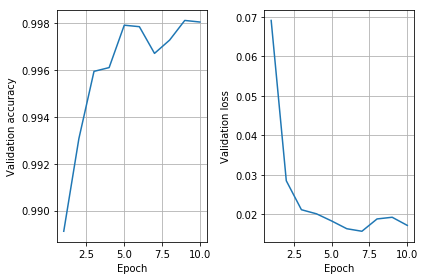

In [23]:
valAcc = history_cb.val_acc
valLoss = history_cb.val_loss
epoch_it = np.arange(1,11)
plt.subplot(121)
plt.plot(epoch_it, valAcc)
plt.grid()
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.subplot(122)
plt.plot(epoch_it, valLoss)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.tight_layout()
plt.show()

In [ ]:
Ls = history_cb.losses
ntr = np.shape(x_train)[0]
epochNum = []
for i in range(49410):
    epochNum.append(i*batch_size/ntr)
matplotlib.pyplot.semilogy(epochNum, Ls)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [ ]:
rates = [0.01,0.001,0.0001]
batch_size = 100
loss_hist = []
val_acc_hist = []

In [ ]:
import keras.backend as K
K.clear_session()

from keras import optimizers

# Create neural net
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(50, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# output layer
model.add(Dense(y.shape[1],activation='softmax'))

opt = optimizers.Adam(lr=rates[0], beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

## compile
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_cb0 = LossHistory()

batch_size = 100
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[history_cb0],verbose=2,epochs=10,batch_size=batch_size)

In [ ]:
import keras.backend as K
K.clear_session()

from keras import optimizers

# Create neural net
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(50, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# output layer
model.add(Dense(y.shape[1],activation='softmax'))

opt = optimizers.Adam(lr=rates[1], beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

## compile
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_cb1 = LossHistory()

batch_size = 100
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[history_cb1],verbose=2,epochs=10,batch_size=batch_size)

In [ ]:
import keras.backend as K
K.clear_session()

from keras import optimizers

# Create neural net
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(50, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# output layer
model.add(Dense(y.shape[1],activation='softmax'))

opt = optimizers.Adam(lr=rates[2], beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

## compile
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_cb2 = LossHistory()

batch_size = 100
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[history_cb2],verbose=2,epochs=10,batch_size=batch_size)

In [ ]:
valAcc0 = history_cb0.val_acc
valAcc1 = history_cb1.val_acc
valAcc2 = history_cb2.val_acc
epoch_it = np.arange(1,11)
plt.plot(epoch_it, valAcc0)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.legend(['rates = 0.01'])
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(epoch_it, valAcc1)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.legend(['rates = 0.001'])
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(epoch_it, valAcc2)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.legend(['rates = 0.0001'])
plt.tight_layout()
plt.show()

In [ ]:
# TODO
Ls2 = history_cb2.losses
Ls0 = history_cb0.losses
Ls1 = history_cb1.losses

ntr = np.shape(x_train)[0]
epochNum = []
for i in range(37060):
    epochNum.append(i*batch_size/ntr)

matplotlib.pyplot.semilogy(epochNum, Ls0, epochNum, Ls1, epochNum, Ls2)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['rates = 0.01','rates = 0.001','rates = 0.0001'])
plt.tight_layout()

plt.show()

In [ ]:
matplotlib.pyplot.semilogy(epochNum, Ls0)
#matplotlib.pyplot.semilogy(epochNum, Ls1)
#matplotlib.pyplot.semilogy(epochNum, Ls2)
plt.legend(['rates = 0.01','rates = 0.001','rates = 0.0001'])
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')